## Optimal Battery Scheduling with Linear Programming

#### _Install and import packages_

In [1]:
!pip install pyomo -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

#### _Generate data_

In [3]:
#generate series by second
days = 7
secs = 60 * 60 * 24 * days
idx = pd.date_range('2022-05-01', periods=secs, freq='S')
idx

DatetimeIndex(['2022-05-01 00:00:00', '2022-05-01 00:00:01',
               '2022-05-01 00:00:02', '2022-05-01 00:00:03',
               '2022-05-01 00:00:04', '2022-05-01 00:00:05',
               '2022-05-01 00:00:06', '2022-05-01 00:00:07',
               '2022-05-01 00:00:08', '2022-05-01 00:00:09',
               ...
               '2022-05-07 23:59:50', '2022-05-07 23:59:51',
               '2022-05-07 23:59:52', '2022-05-07 23:59:53',
               '2022-05-07 23:59:54', '2022-05-07 23:59:55',
               '2022-05-07 23:59:56', '2022-05-07 23:59:57',
               '2022-05-07 23:59:58', '2022-05-07 23:59:59'],
              dtype='datetime64[ns]', length=604800, freq='S')

In [4]:
#generate random data
np.random.seed(42)
x = np.linspace(1, days * 2 * np.pi, num=secs)+2

load = pd.Series(0.3 * np.sin(x) + 0.8 + np.random.normal(scale=5, size=len(x)))
pv1 = pd.Series(0.8 * np.sin(x+2) + 0.1 + np.random.normal(scale=3, size=len(x)))
buy_price = pd.Series(0.5 * np.sin(x) + 1.5)*0.03
sell_price = pd.Series(np.full(len(x), 0.03))
df = pd.concat([load, pv1, buy_price, sell_price], axis=1).set_index(idx)
df.columns = ['load', 'pv1', 'buy_price', 'sell_price']

df.head()

,load,pv1,buy_price,sell_price
2022-05-01 00:00:00,3.325907,-1.406518,0.047117,0.03
2022-05-01 00:00:01,0.150993,-5.243328,0.047116,0.03
2022-05-01 00:00:02,4.080736,-0.927141,0.047115,0.03
2022-05-01 00:00:03,8.457422,2.251508,0.047114,0.03
2022-05-01 00:00:04,-0.328515,-4.455911,0.047113,0.03


<AxesSubplot:>

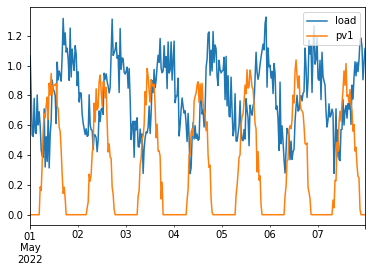

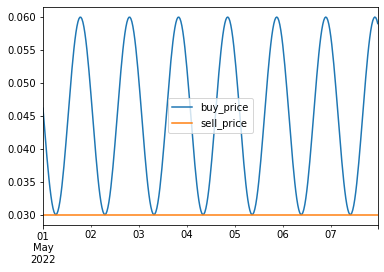

In [5]:
#plot
df = df.resample('30T').mean()

for j,e in enumerate(df['pv1']):
  if e >= 0:
    df['pv1'][j] = e
  else:
    df['pv1'][j] = 0

df[['load', 'pv1']].plot()
df[['buy_price', 'sell_price']].plot()

#### _Set up linear programming task. Credit: Edward Barbour_

In [6]:
#create indexed variables
priceDict1 = dict(enumerate(df['sell_price']))
priceDict2 = dict(enumerate(df['buy_price']))

buy_price = df['buy_price'].values
sell_price = df['sell_price'].values
load = df['load'].values
pv1 = df['load'].values

In [7]:
#create variable for net demand
#if net > 0 buy from grid, if net < 0 sell to grid
net = df['load'] - df['pv1']

#split into two arrays
posLoad = np.copy(net)
negLoad = np.copy(net)

for j,e in enumerate(net):
  if e >= 0:
    negLoad[j] = 0
  else:
    posLoad[j] = 0

posLoadDict = dict(enumerate(posLoad))
negLoadDict = dict(enumerate(negLoad))

In [8]:
#cost of electricity for a week without battery storage
cost_without_battery = np.sum([(posLoad[i] * buy_price[i] + negLoad[i] * sell_price[i]) for i in range(len(buy_price))])
print(cost_without_battery)

8.480526315258974


In [9]:
#set up model
from pyomo.opt import SolverFactory
from pyomo.core import Var
import pyomo.environ as en

m = en.ConcreteModel()

#set time as model index
m.Time = en.RangeSet(0, len(net)-1)

In [10]:
capacity = 1.5
charging_power_limit = 1.0
discharging_power_limit = -1.0
charging_efficiency = 0.95
discharging_efficiency = 0.95

In [11]:
# set variables
m.SOC = en.Var(m.Time, bounds=(0,capacity), initialize=0) #0
m.posDeltaSOC = en.Var(m.Time, initialize=0) #1
m.negDeltaSOC = en.Var(m.Time, initialize=0) #2
m.posEInGrid = en.Var(m.Time, bounds=(0,charging_power_limit*(30/60.)), initialize=0) #3
m.posEInPV = en.Var(m.Time, bounds=(0,charging_power_limit*(30/60.)), initialize=0) #4
m.negEOutLocal = en.Var(m.Time, bounds=(discharging_power_limit*(30/60.),0), initialize=0) #5
m.negEOutExport = en.Var(m.Time, bounds=(discharging_power_limit*(30/60.),0), initialize=0) #6
m.posNetLoad = en.Var(m.Time, initialize=posLoadDict) #7
m.negNetLoad = en.Var(m.Time, initialize=negLoadDict) #8

In [12]:
# Boolean variables (again indexed by Time)
m.Bool_char=en.Var(m.Time,within=en.Boolean) #9
m.Bool_dis=en.Var(m.Time,within=en.Boolean,initialize=0) #10

In [13]:
# parameters (indexed by time)
m.priceSell = en.Param(m.Time, initialize=priceDict1)
m.priceBuy = en.Param(m.Time, initialize=priceDict2)
m.posLoad = en.Param(m.Time, initialize=posLoadDict)
m.negLoad = en.Param(m.Time, initialize=negLoadDict)

In [14]:
# single value parameters
m.etaChg = en.Param(initialize = charging_efficiency)
m.etaDisChg = en.Param(initialize = discharging_efficiency)
m.ChargingLimit = en.Param(initialize = charging_power_limit*(30/60.))
m.DischargingLimit = en.Param(initialize = discharging_power_limit*(30/60.))

In [15]:
# objective function
def Obj_fn(m):
    return sum((m.priceBuy[i]*m.posNetLoad[i]) + (m.priceSell[i]*m.negNetLoad[i]) for i in m.Time)  
m.total_cost = en.Objective(rule=Obj_fn,sense=en.minimize)

In [16]:
#battery capacity constraint
def SOC_rule(m,t):
    if t==0:
        return (m.SOC[t] == m.posDeltaSOC[t]+m.negDeltaSOC[t])
    else:
        return (m.SOC[t] == m.SOC[t-1]+m.posDeltaSOC[t]+m.negDeltaSOC[t])   
#index by time
m.Batt_SOC = en.Constraint(m.Time,rule=SOC_rule)

In [17]:
#ensure charging efficiency is divided
def pos_E_in_rule(m,i):
    return (m.posEInGrid[i]+m.posEInPV[i]) == m.posDeltaSOC[i]/m.etaChg
m.posEIn_cons = en.Constraint(m.Time, rule=pos_E_in_rule)
# ensure discharging eff multiplied
def neg_E_out_rule(m,i):
    return (m.negEOutLocal[i]+m.negEOutExport[i]) == m.negDeltaSOC[i]*m.etaDisChg
m.negEOut_cons = en.Constraint(m.Time, rule=neg_E_out_rule)

In [18]:
# ensure charging rate obeyed
def E_charging_rate_rule(m,i):
    return (m.posEInGrid[i]+m.posEInPV[i])<=m.ChargingLimit
m.chargingLimit_cons = en.Constraint(m.Time, rule=E_charging_rate_rule)
# ensure DIScharging rate obeyed
def E_discharging_rate_rule(m,i):
    return (m.negEOutLocal[i]+m.negEOutExport[i])>=m.DischargingLimit
m.dischargingLimit_cons = en.Constraint(m.Time, rule=E_discharging_rate_rule)

In [19]:
# ensure that posEInPV cannot exceed local PV
def E_solar_charging_rule(m,i):
    return m.posEInPV[i]<=-m.negLoad[i]
m.solarChargingLimit_cons = en.Constraint(m.Time, rule=E_solar_charging_rule)
# ensure that negEOutLocal cannot exceed local demand
def E_local_discharge_rule(m,i):
    return m.negEOutLocal[i]>=-m.posLoad[i]
m.localDischargingLimit_cons = en.Constraint(m.Time, rule=E_local_discharge_rule)

In [20]:
# calculate the net positive demand
def E_pos_net_rule(m,i):
    return m.posNetLoad[i] == m.posLoad[i]+m.posEInGrid[i]+m.negEOutLocal[i]
m.E_posNet_cons = en.Constraint(m.Time,rule=E_pos_net_rule)

# calculate export
def E_neg_net_rule(m,i):
    return m.negNetLoad[i] == m.negLoad[i]+m.posEInPV[i]+m.negEOutExport[i]
m.E_negNet_cons = en.Constraint(m.Time,rule=E_neg_net_rule)

#### _Run CBC solver_

In [21]:
#import cplex
opt = SolverFactory('cbc')

In [22]:
#time it for good measure
t = time.time()
results = opt.solve(m)
elapsed = time.time() - t
print('Time elapsed:', elapsed)

Time elapsed: 0.18895697593688965


In [23]:
# now let's read in the value for each of the variables 
outputVars = np.zeros((9,len(sell_price)))

j = 0
for v in m.component_objects(Var, active=True):
    print(v.getname())
    varobject = getattr(m, str(v))
    for index in varobject:
        outputVars[j,index] = varobject[index].value
    j+=1
    if j>=9:
        break

SOC
posDeltaSOC
negDeltaSOC
posEInGrid
posEInPV
negEOutLocal
negEOutExport
posNetLoad
negNetLoad


### _Results_

In [24]:
#get the total cost
cost_with_battery = np.sum([(buy_price[i]*outputVars[7,i] + sell_price[i]*outputVars[8,i]) 
                            for i in range(len(buy_price))])

print('Cost without battery:', cost_without_battery)
print('Cost with battery:', cost_with_battery)
print('Score: %.4f'%((cost_with_battery - cost_without_battery) / np.abs(cost_without_battery)))

Cost without battery: 8.480526315258974
Cost with battery: 8.213141952200605
Score: -0.0315


<AxesSubplot:>

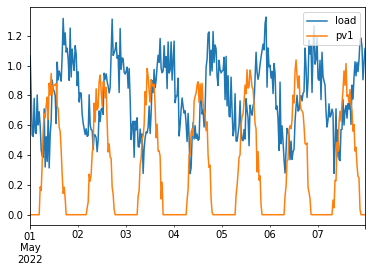

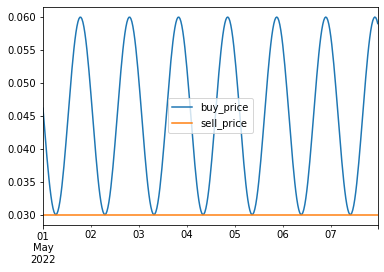

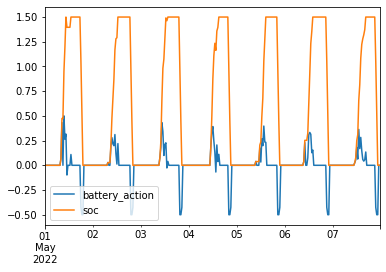

In [25]:
df[['load', 'pv1']].plot()
df[['buy_price', 'sell_price']].plot()

df['battery_action'] = np.sum(outputVars[3:7,:], axis=0)
df['soc'] = outputVars[0]

df[['battery_action', 'soc']].plot()